In [ ]:
import os
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Downloading the dataset
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

168052/168052 [==============================] - 0s 1us/step


In [ ]:
# Loading dataset into a Pandas dataframe
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [ ]:
# Displaying a sample of the citations dataframe.
# Here, target column includes paper ids cited by paper ids in source column
citations.sample(frac=1).head()

,target,source
4164,134128,1113614
2985,38722,5038
916,3233,509379
3057,40135,13686
4431,189566,310742


In [ ]:
citations

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [ ]:
# Loading papers data into another pandas dataframe
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [ ]:
# Displaying a sample of the papers dataframe.
# papers includes the paper_id and the subject columns
# Also, 1433 binary column representing whether a term exists in the paper or not.
papers.sample(5).T

,2639,1564,778,229,455
paper_id,1139009,42847,217115,1136422,64484
term_0,0,0,0,0,0
term_1,0,0,0,0,0
term_2,0,0,0,0,0
term_3,0,0,0,0,0
...,...,...,...,...,...
term_1429,0,0,0,0,0
term_1430,0,0,0,0,0
term_1431,0,0,0,0,0
term_1432,0,0,0,0,0


In [ ]:
print(papers['subject'].unique())

['Neural_Networks' 'Rule_Learning' 'Reinforcement_Learning'
 'Probabilistic_Methods' 'Theory' 'Genetic_Algorithms' 'Case_Based']


In [ ]:
print(papers.sample(5).T)

             517                 714                     633   \
paper_id    12960              646809                   28278   
term_0          0                   0                       0   
term_1          0                   0                       0   
term_2          0                   0                       0   
term_3          0                   0                       0   
...           ...                 ...                     ...   
term_1429       0                   0                       0   
term_1430       0                   0                       0   
term_1431       0                   0                       0   
term_1432       0                   0                       0   
subject    Theory  Genetic_Algorithms  Reinforcement_Learning   

                         2667    52    
paper_id               427606    8699  
term_0                      0       0  
term_1                      0       0  
term_2                      0       0  
term_3             

In [ ]:
# Displaying the paper count in each subject
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [ ]:
# Converting the paper ids and the subjects into zero-based indices
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])


In [ ]:
l1 = papers["subject"].tolist()

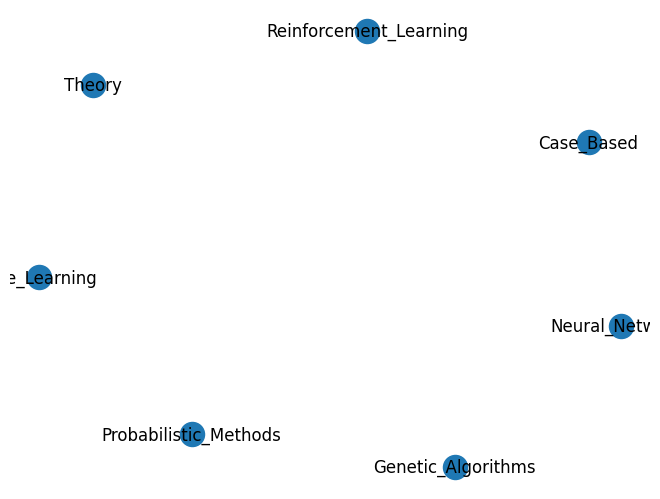

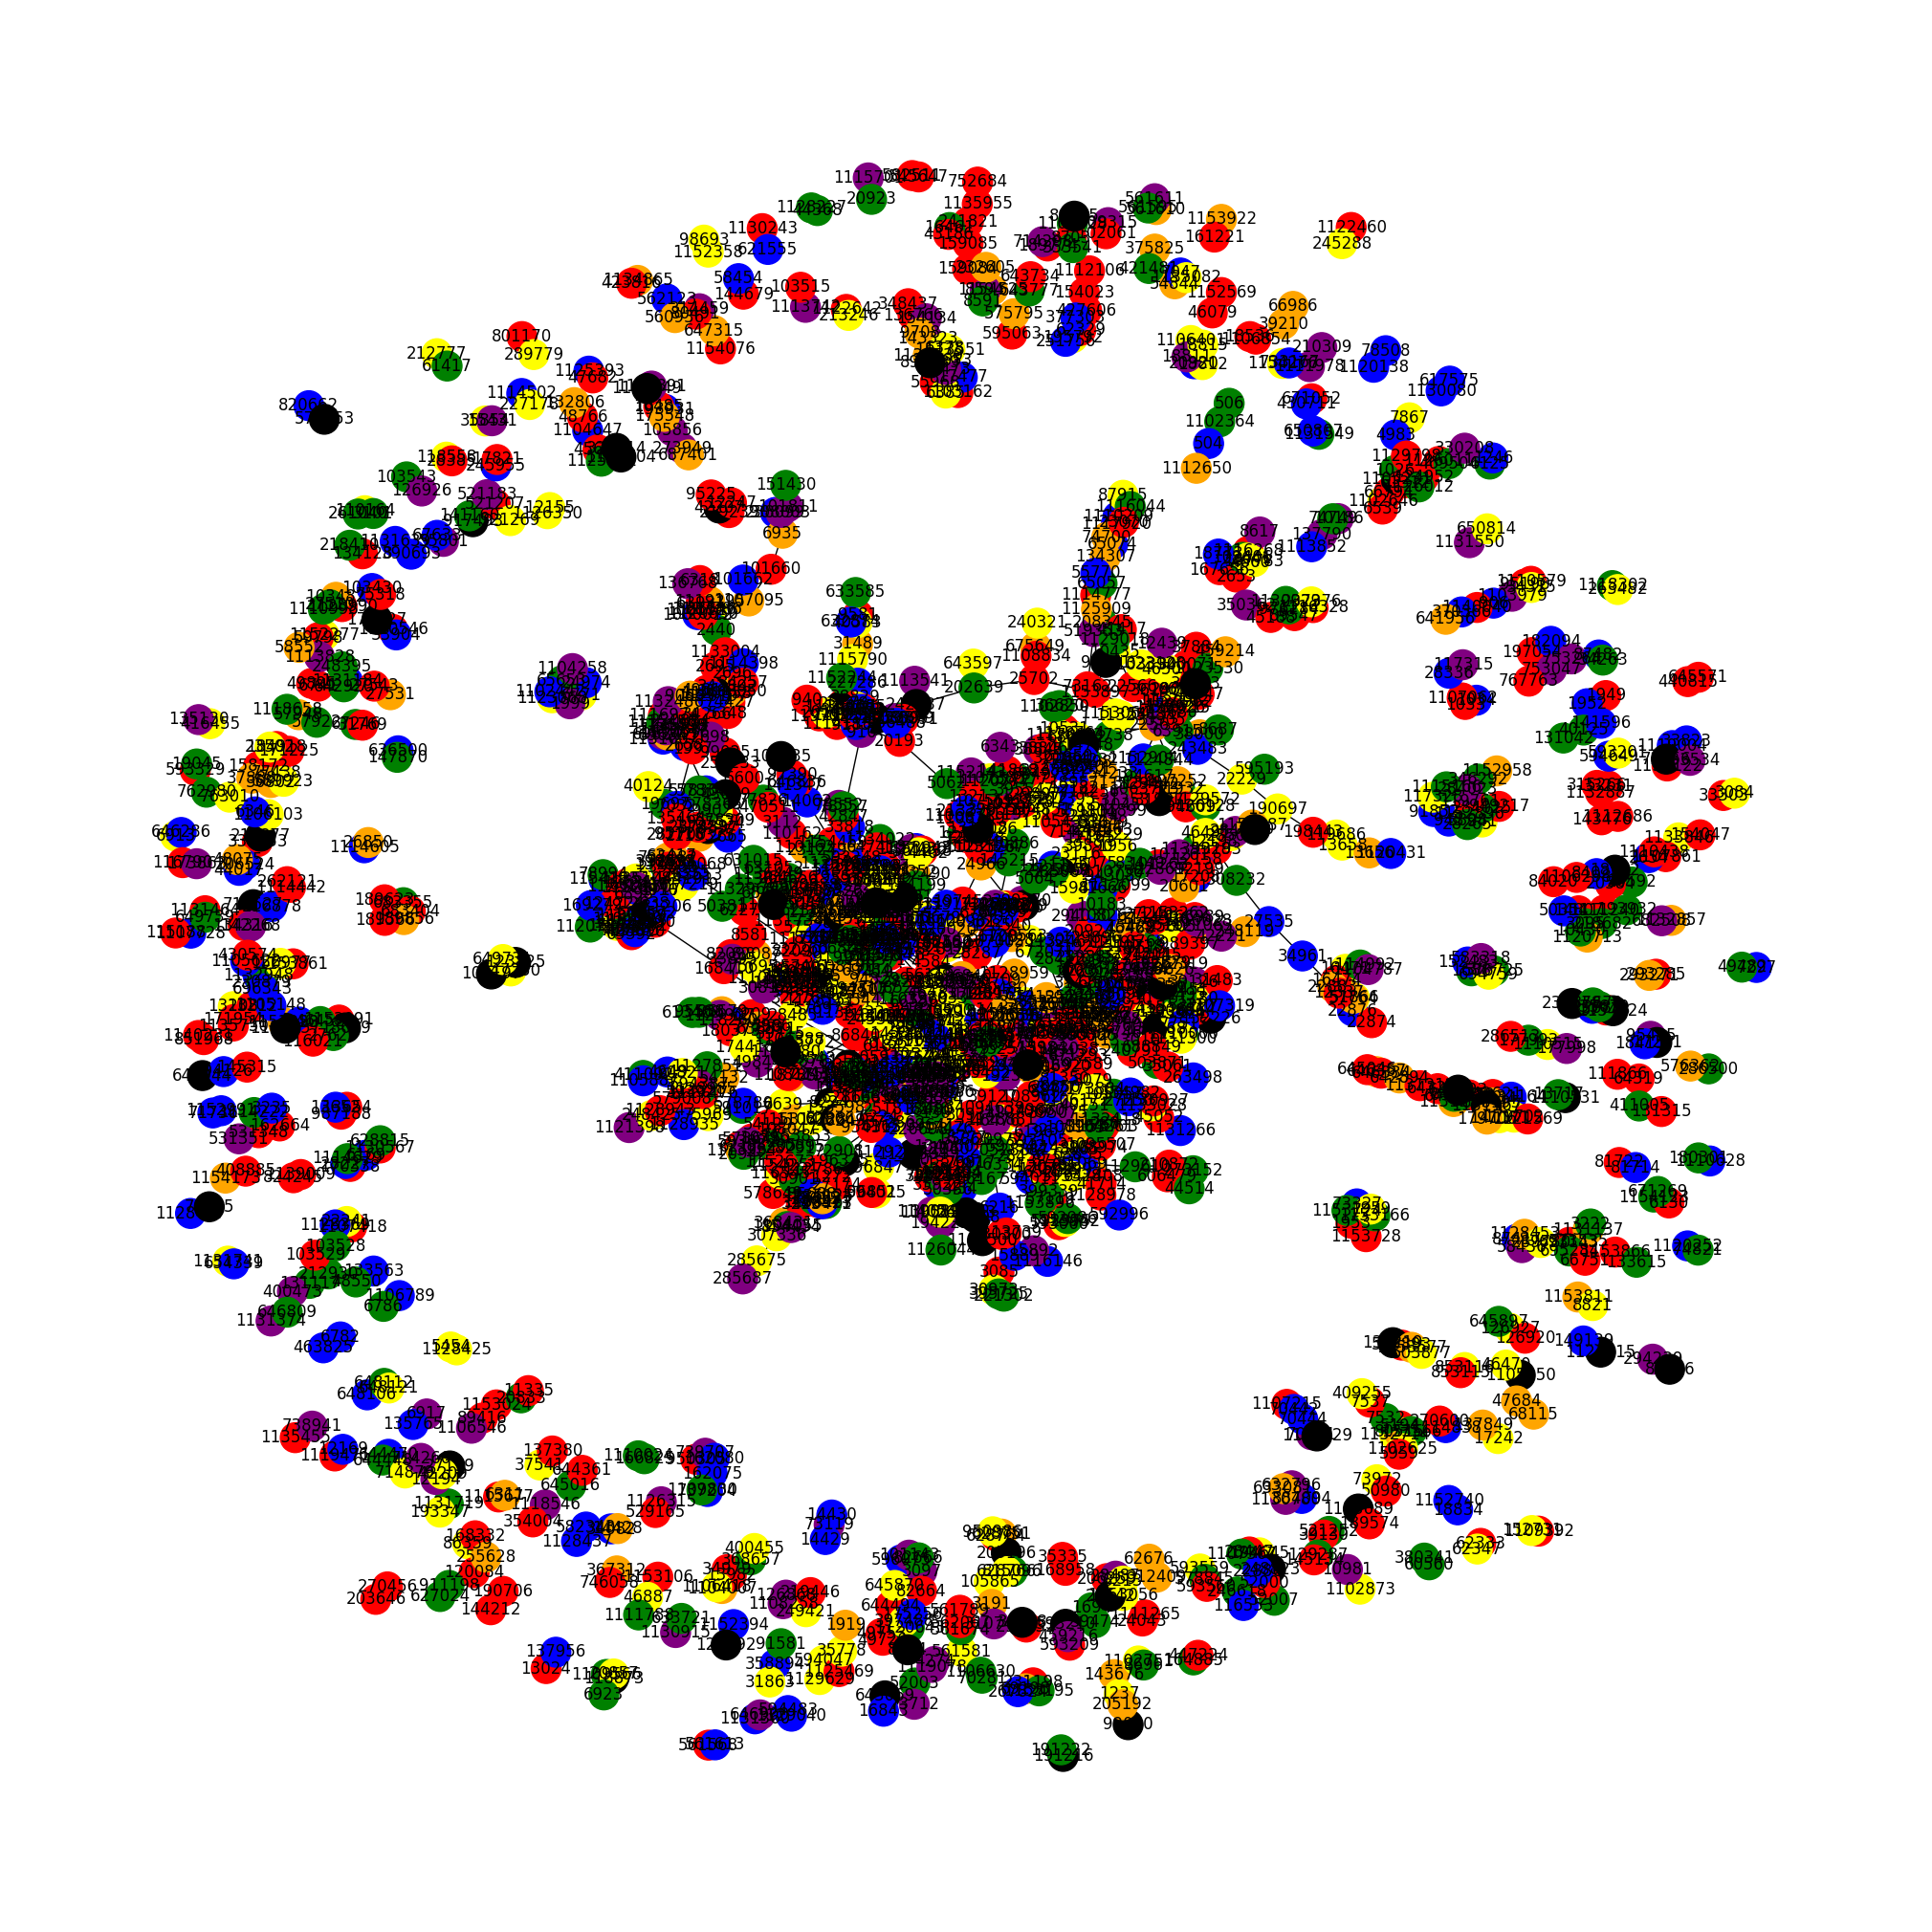

In [ ]:
# Visualizing the citation graph
# Each node => a paper
# Color of node => Subject

plt1.figure(figsize=(20, 20))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])

color_mapping = {
    'Neural_Networks': 'red',
    'Probabilistic_Methods': 'blue',
    'Genetic_Algorithms': 'green',
    'Theory': 'yellow',
    'Case_Based': 'purple',
    'Reinforcement_Learning': 'orange',
    'Rule_Learning': 'black'
}
labels = {}
for i in range(0,len(l1)):
    if l1[i] in color_mapping:
        labels[i] = l1[i]


node_colors = [color_mapping[subject] for subject in subjects]

nx.draw(cora_graph, node_size=500, node_color=node_colors, with_labels=True)

In [ ]:
# Splitting the dataset into stratified train and test sets
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1357, 1435)
Test data shape: (1351, 1435)


In [ ]:
# Implement train and evaluate experiment
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
# Displays the loss and accuracy curves of the model during training.
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [ ]:
# Implement Feedforward Network (FFN) Module
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
# Build a Baseline Neural Network Model
# Prepare the data for the baseline model

feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

NameError: ignored